In [1]:
!pip install -q -U bitsandbytes transformers peft accelerate datasets scipy einops evaluate trl

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 24.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
kfp 2.5.0 requires google-cloud-storage<3,>=2.2.1, but you have google-cloud-storage 1.44.0 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.2 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pointpats 2.5.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
spaghetti 1.7.6 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.1 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which 

In [2]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
# disable Weights and Biases
os.environ['WANDB_DISABLED']="true"

In [4]:
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    GenerationConfig
)
from tqdm import tqdm
from trl import SFTTrainer
import torch
import time
import pandas as pd
import numpy as np
from huggingface_hub import interpreter_login

from datasets import load_dataset,Dataset,DatasetDict
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
nltk.download('punkt')
nltk.download('stopwords')

2024-07-17 04:09:07.297069: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 04:09:07.297168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 04:09:07.459317: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
import os 
os.environ['CUDA_IS_VISIBLE'] = '0,1'
import sys
import gc
import re
import ctypes
import random
from tqdm import tqdm
import polars as pl

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score,accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold

In [6]:
from pynvml import *

def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

In [7]:
train= pd.read_csv("/kaggle/input/medicaldataset/medical_tc_train.csv")
train.rename(columns = {'condition_label':'label','medical_abstract':'text'}, inplace=True)
train['label']=train['label']-1
train.head()

,label,text
0,4,Tissue changes around loose prostheses. A cani...
1,0,Neuropeptide Y and neuron-specific enolase lev...
2,1,"Sexually transmitted diseases of the colon, re..."
3,0,Lipolytic factors associated with murine and h...
4,2,Does carotid restenosis predict an increased r...


In [8]:
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Split text into words
    words = text.split()
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Join words back into a single string
    cleaned_text = ' '.join(words)
    
    return cleaned_text

In [9]:
train['text'] = train['text'].apply(clean_text)

print(train)

       label                                               text
0          4  tissue changes around loose prostheses canine ...
1          0  neuropeptide neuronspecific enolase levels ben...
2          1  sexually transmitted diseases colon rectum anu...
3          0  lipolytic factors associated murine human canc...
4          2  carotid restenosis predict increased risk late...
...      ...                                                ...
11545      0  epirubicin two dose levels prednisolone treatm...
11546      0  four half year follow women dyskaryotic cervic...
11547      4  safety transbronchial biopsy outpatients objec...
11548      2  interictal spikes hippocampal somatostatin lev...
11549      4  recurrent thoracic outlet syndrome first rib r...

[11550 rows x 2 columns]


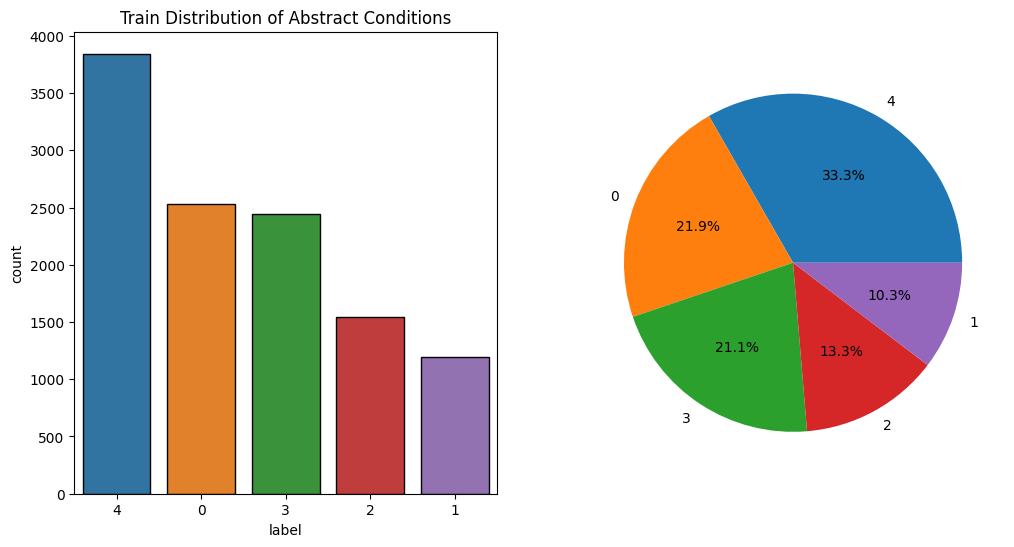

In [10]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train Distribution of Abstract Conditions')
sns.countplot(x=train['label'], edgecolor='black', order=train['label'].value_counts().index)
plt.subplot(1,2,2)
plt.pie(x=train['label'].value_counts(), labels=train['label'].value_counts().index, autopct='%.1f%%')
plt.show()

In [11]:
test= pd.read_csv("/kaggle/input/medicaldataset/medical_tc_test.csv")
test.rename(columns = {'condition_label':'label','medical_abstract':'text'}, inplace=True)
test['label']=test['label']-1
test.head()

,label,text
0,2,Obstructive sleep apnea following topical orop...
1,4,Neutrophil function and pyogenic infections in...
2,4,A phase II study of combined methotrexate and ...
3,0,Flow cytometric DNA analysis of parathyroid tu...
4,3,Paraneoplastic vasculitic neuropathy: a treata...


In [12]:
test['text'] = test['text'].apply(clean_text)

print(test)

      label                                               text
0         2  obstructive sleep apnea following topical orop...
1         4  neutrophil function pyogenic infections bone m...
2         4  phase ii study combined methotrexate teniposid...
3         0  flow cytometric dna analysis parathyroid tumor...
4         3  paraneoplastic vasculitic neuropathy treatable...
...     ...                                                ...
2883      3  management aortobronchial fistula graft replac...
2884      4  tuberculous psoas muscle abscess following che...
2885      3  clinical evaluation highfrequency ultrasonic m...
2886      0  antitumor activity liposomeencapsulated doxoru...
2887      3  unusual venous anomaly placenta authors presen...

[2888 rows x 2 columns]


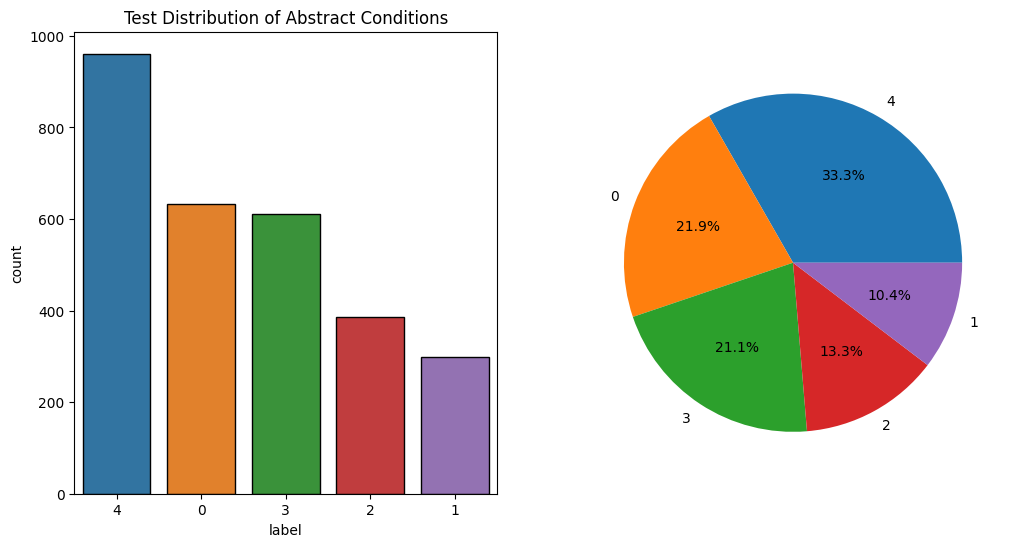

In [13]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Test Distribution of Abstract Conditions')
sns.countplot(x=test['label'], edgecolor='black', order=train['label'].value_counts().index)
plt.subplot(1,2,2)
plt.pie(x=test['label'].value_counts(), labels=test['label'].value_counts().index, autopct='%.1f%%')
plt.show()

In [14]:
train = train[['text', 'label']]
print(train)

                                                    text  label
0      tissue changes around loose prostheses canine ...      4
1      neuropeptide neuronspecific enolase levels ben...      0
2      sexually transmitted diseases colon rectum anu...      1
3      lipolytic factors associated murine human canc...      0
4      carotid restenosis predict increased risk late...      2
...                                                  ...    ...
11545  epirubicin two dose levels prednisolone treatm...      0
11546  four half year follow women dyskaryotic cervic...      0
11547  safety transbronchial biopsy outpatients objec...      4
11548  interictal spikes hippocampal somatostatin lev...      2
11549  recurrent thoracic outlet syndrome first rib r...      4

[11550 rows x 2 columns]


In [15]:
test = test[['text', 'label']]
print(test)

                                                   text  label
0     obstructive sleep apnea following topical orop...      2
1     neutrophil function pyogenic infections bone m...      4
2     phase ii study combined methotrexate teniposid...      4
3     flow cytometric dna analysis parathyroid tumor...      0
4     paraneoplastic vasculitic neuropathy treatable...      3
...                                                 ...    ...
2883  management aortobronchial fistula graft replac...      3
2884  tuberculous psoas muscle abscess following che...      4
2885  clinical evaluation highfrequency ultrasonic m...      3
2886  antitumor activity liposomeencapsulated doxoru...      0
2887  unusual venous anomaly placenta authors presen...      3

[2888 rows x 2 columns]


In [16]:
train.to_csv("medical_tc_train_modified.csv", index=False)
test.to_csv("medical_tc_test_modified.csv", index=False)

#  **BERT+QLORA**


In [17]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [18]:
dataset  = load_dataset('csv', data_files={'train': '/kaggle/working/medical_tc_train_modified.csv',
                                          'test': '/kaggle/working/medical_tc_test_modified.csv'})
dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 11550
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2888
    })
})

In [19]:
def tokenize_function(examples):
    tokenized_inputs = tokenizer(examples["text"], padding="max_length", truncation=True)
    tokenized_inputs["labels"] = examples["label"]
    return tokenized_inputs

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/11550 [00:00<?, ? examples/s]

Map:   0%|          | 0/2888 [00:00<?, ? examples/s]

In [20]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 11550
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2888
    })
})

In [21]:
# Function to reorder the columns in a dataset
def reorder_columns(dataset, column_order):
    # Select the columns in the specified order
    return dataset.select_columns(column_order)

# Desired column order
column_order = ['attention_mask', 'input_ids', 'label', 'text', 'token_type_ids']

# Reorder columns in train and test datasets
reordered_train = reorder_columns(tokenized_datasets['train'], column_order)
reordered_test = reorder_columns(tokenized_datasets['test'], column_order)

# Create a new DatasetDict with reordered columns
reordered_dataset = DatasetDict({
    'train': reordered_train,
    'test': reordered_test
})

# Verify the structure
print(reordered_dataset)

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text', 'token_type_ids'],
        num_rows: 11550
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text', 'token_type_ids'],
        num_rows: 2888
    })
})


In [22]:
# BitsAndBytes config for QLoRA
compute_dtype = getattr(torch, "float16")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False,
)
device_map = {"": 0}

In [23]:
# Define train and test sets
train_dataset = reordered_dataset['train']
eval_dataset = reordered_dataset['test']

In [24]:
from transformers import BertForSequenceClassification

original_model = BertForSequenceClassification.from_pretrained(
    'bert-large-uncased', 
    num_labels=5
)

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(original_model))

trainable model parameters: 335147013
all model parameters: 335147013
percentage of trainable model parameters: 100.00%


In [26]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
config =LoraConfig(task_type="SEQ_CLS", inference_mode=False, r=8, lora_alpha=16, lora_dropout=0.1)
# 1 - Enabling gradient checkpointing to reduce memory usage during fine-tuning
original_model.gradient_checkpointing_enable()

# 2 - Using the prepare_model_for_kbit_training method from PEFT
original_model = prepare_model_for_kbit_training(original_model)

peft_model = get_peft_model(original_model, config)

print(print_number_of_trainable_model_parameters(peft_model))
# See how the model looks different now, with the LoRA adapters added:
print(peft_model)

trainable model parameters: 791557
all model parameters: 335938570
percentage of trainable model parameters: 0.24%
PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 1024, padding_idx=0)
          (position_embeddings): Embedding(512, 1024)
          (token_type_embeddings): Embedding(2, 1024)
          (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-23): 24 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dro

In [27]:
print_gpu_utilization()

GPU memory occupied: 116 MB.


In [28]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

In [29]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from scipy.stats import gmean

In [30]:
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    acc = accuracy_score(p.label_ids, preds)
    cm = confusion_matrix(p.label_ids, preds)
    gm = gmean([precision, recall])  # Calculate the Geometric Mean of precision and recall

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'geometric_mean': gm,  # Include Geometric Mean
        
    }

In [31]:
output_dir = './peft-dialogue-summary-training/final-checkpoint'
import transformers

# Training arguments
peft_training_args = TrainingArguments(
    output_dir=output_dir,
    warmup_steps=0,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    max_steps=2000,
    learning_rate=2e-4,
    optim="paged_adamw_8bit",
    logging_steps=25,
    logging_dir="./logs",
    save_strategy="steps",
    save_steps=25,
    evaluation_strategy="steps",
    eval_steps=25,
    do_eval=True,
    gradient_checkpointing=True,
    report_to="none",
    overwrite_output_dir=True,
    group_by_length=True,
)

peft_model.config.use_cache = False

# Define train and test sets
train_dataset = reordered_dataset['train']
eval_dataset = reordered_dataset['test']

# Trainer setup
peft_trainer = Trainer(
    model=peft_model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    args=peft_training_args,
    compute_metrics=compute_metrics,
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


In [32]:
peft_training_args.device

device(type='cuda', index=0)

In [33]:
peft_trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Geometric Mean
25,1.645700,1.598488,0.332756,0.166162,0.110727,0.332756,0.191951
50,1.578900,1.570759,0.332756,0.166162,0.110727,0.332756,0.191951
75,1.540300,1.616563,0.221607,0.087507,0.103341,0.221607,0.151331
100,1.609700,1.641253,0.332756,0.166162,0.110727,0.332756,0.191951
125,1.701100,1.663515,0.212604,0.078864,0.114321,0.212604,0.155901
150,1.607100,1.522916,0.324100,0.279595,0.248242,0.324100,0.283646
175,1.562300,1.626051,0.225762,0.095245,0.129971,0.225762,0.171297
200,1.601000,1.487153,0.339681,0.191441,0.365088,0.339681,0.352155
225,1.427500,1.538528,0.333449,0.167629,0.329986,0.333449,0.331713
250,1.566000,1.512666,0.406856,0.294264,0.237820,0.406856,0.311060


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to

TrainOutput(global_step=2000, training_loss=1.2174552164077759, metrics={'train_runtime': 15148.9929, 'train_samples_per_second': 0.528, 'train_steps_per_second': 0.132, 'total_flos': 7474979782656000.0, 'train_loss': 1.2174552164077759, 'epoch': 0.6926406926406926})

In [34]:
# Step 9: Evaluate the model
eval_result = peft_trainer.evaluate()

# Step 10: Print the evaluation results
print(f"Accuracy: {eval_result['eval_accuracy']}")
print(f"F1 Score: {eval_result['eval_f1']}")
print(f"Precision: {eval_result['eval_precision']}")
print(f"Recall: {eval_result['eval_recall']}")
print(f"Geometric Mean: {eval_result['eval_geometric_mean']}")

Accuracy: 0.5505540166204986
F1 Score: 0.485276176948479
Precision: 0.5233446129180375
Recall: 0.5505540166204986
Geometric Mean: 0.5367769357179252


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
